In [116]:
import numpy as np
import pandas as pd
import pickle

from functools import partial
from pyts.image import GADF, GASF, MTF # Package to convert time series into images
import matplotlib.pyplot as plt
import numexpr as ne # Fast way to navigate and search in pd.DataFrame objects
import time # Time the program
from multiprocessing import Pool # Enable multiprocessing to speed up the code

# Loading data

Most of the stocks have common trading dates except for very few stocks that don't align with the rest. Take their most common trading dates. Result in loss of only 1 trading date information.

In [18]:
## Run this block of code if it is your first time to load in 'reduced_stock' and try to save them into a new 'newData'

# with open('reduced_stock','rb') as p:
#     df = pickle.load(p)
#     p.close()
    
# all_permno = np.unique(df.index.values)
# all_dates = df.loc[all_permno[0]].date.values
# for stockId in all_permno[1:]:
#     all_dates = np.intersect1d(all_dates, df.loc[stockId].date.values)
# df = df[df.date.isin(all_dates)]

# with open('newData','wb') as f:
#     pickle.dump(df, f)
#     f.close()


In [23]:
with open('newData','rb') as p:
    df = pickle.load(p)
    p.close()
    
df = df.reset_index(drop=False).set_index(['PERMNO', 'date'])

# Overview of the data
The following summarize various aspects of the data to use in the research.

1) Number of stocks;

2) Number of trading dates; 

3) Starting vs ending dates; 

4) Number of features and features names.

In [25]:
all_permno = np.unique([x[0] for x in df.index.values])
all_dates = df.loc[all_permno[0]].index.values
nFeatures = df.shape[1]

print('number of stocks:', len(all_permno))
print('number of trading dates:', len(all_dates))
print('starting date:', all_dates.min())
print('ending date:', all_dates.max())
print('number of features:', nFeatures)
print('Feature names:', df.columns.values)

number of stocks: 1367
number of trading dates: 5539
starting date: 19960102
ending date: 20171229
number of features: 4
Feature names: ['PRC' 'VOL' 'BIDLO' 'ASKHI']


In [26]:
# Some sample data
print (df.head())
print (df.tail())

                    PRC       VOL   BIDLO   ASKHI
PERMNO date                                      
63773  19960102  39.750   61400.0  39.125  39.875
       19960103  39.875  105000.0  39.500  40.125
       19960104  39.750   69500.0  39.500  40.000
       19960105  40.500   42800.0  39.375  40.500
       19960108  40.125   46300.0  40.125  40.625
                   PRC        VOL  BIDLO  ASKHI
PERMNO date                                    
56274  20171222  38.08  2880973.0  37.92  38.26
       20171226  38.21  1890332.0  38.02  38.63
       20171227  38.07  2696672.0  37.95  38.36
       20171228  38.05  1876344.0  37.68  38.22
       20171229  37.67  2392097.0  37.65  38.24


# Convert time-series into multi-channel images
This section bases completely on some papers that proposes the conversion of time-series into graphs. This conversion typically preserves the correlation of time-series while encodes information of time progression. See Wang and Oates (2015), for example.

## Hyper-parameters settings
Hyper parameters description:
    1. image_size: the number of pixels for the image generated.
    2. data_len: length of the data to construct one single image. Default 252/4, i.e. one quarter of data
    3. retrain_freq: for how many days do we re-generate an image. Default 5, i.e. generate new images every week

Note that the ratio of data_len/image_size determines how much you compressed orgininal time series to generate images. Also, retrain_freq is directly linked to the information losses: if too small there is too low variation within samples; if too large, too much information lost during resampling, resulting in poor generalization.


In [64]:
image_size = 16
data_len = int(252/4)+1
retrain_freq = 5
nPoints = len(all_dates)

## 1-D sample demonstration
Only use price as the features for CNN. Used relevant hyper paremters.

In [28]:
OneDimSample = df['PRC']

# Example of graphs of one stock throughout sampling period:

OneStock1d = OneDimSample.loc[df.index.values[0][0]].reshape((1,-1))
gadf, gasf, mtf = GADF(image_size), GASF(image_size), MTF(image_size)
OneStockSample1d_gadf, OneStockSample1d_gasf, OneStockSample1d_mtf = [], [], []

for i in range(data_len, nPoints, retrain_freq):
    series = OneStock1d[:,i-data_len:i]
    OneStockSample1d_gadf.append(gadf.fit_transform(series))
    OneStockSample1d_gasf.append(gasf.fit_transform(series))
    OneStockSample1d_mtf.append(mtf.fit_transform(series))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


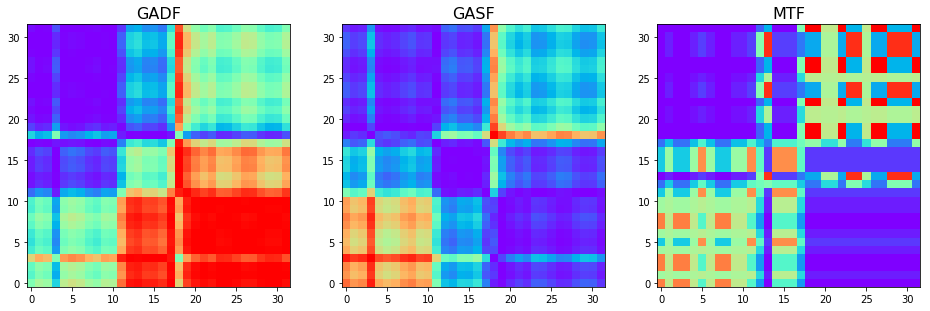

In [29]:
# Plot the 1st image (generated by data of first data_len days): GADF, GASF, MTF

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(OneStockSample1d_gadf[0].squeeze(), cmap='rainbow', origin='lower')
plt.title("GADF", fontsize=16)
plt.subplot(132)
plt.imshow(OneStockSample1d_gasf[0].squeeze(), cmap='rainbow', origin='lower')
plt.title("GASF", fontsize=16)
plt.subplot(133)
plt.imshow(OneStockSample1d_mtf[0].squeeze(), cmap='rainbow', origin='lower')
plt.title("MTF", fontsize=16)
plt.show()

## 4-Channel sample demo
Use all 4 features to construct 4-channel graphs. The way to do it is simply stacking graphs of 4 1-channel graphs produced by time-series of the features.

In [30]:
OneStock4d = df.loc[df.index.values[0][0]].T
gadf, gasf, mtf = GADF(image_size), GASF(image_size), MTF(image_size)
OneStockSample4d_gadf, OneStockSample4d_gasf, OneStockSample4d_mtf = [], [], []

for i in range(data_len, nPoints, retrain_freq):
    series = OneStock4d.iloc[:,i-data_len:i].values
    OneStockSample4d_gadf.append(gadf.fit_transform(series))
    OneStockSample4d_gasf.append(gasf.fit_transform(series))
    OneStockSample4d_mtf.append(mtf.fit_transform(series))

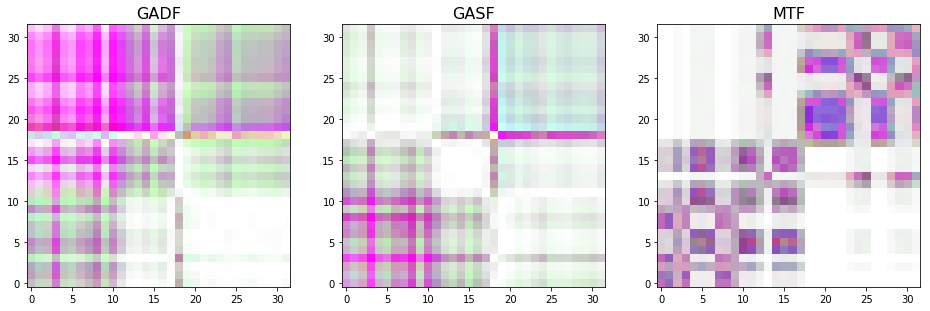

In [31]:
# Plot the 1st image (generated by data of first data_len days): GADF, GASF, MTF

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow((OneStockSample4d_gadf[0].T+1)*0.5, cmap='rainbow', origin='lower')
plt.title("GADF", fontsize=16)
plt.subplot(132)
plt.imshow((1+OneStockSample4d_gasf[0].T)*0.5, cmap='rainbow', origin='lower')
plt.title("GASF", fontsize=16)
plt.subplot(133)
plt.imshow(OneStockSample4d_mtf[0].T, cmap='rainbow', origin='lower')
plt.title("MTF", fontsize=16)
plt.show()

## Prepare all samples for training and testing

The following class gives a general way to convert a series of historical data of one stock into images samples and store them. Due to the relative short period of time used to construct one image, only GADF and GASF samples are created for training. MTF is not information-rich enough in each pixel to capture useful patterns.



In [67]:
class CNNSamples:
    
    def __init__(self, stockData, 
                 data_len=64, 
                 image_size=16, 
                 retrain_freq=5):
        
        self.permno = stockData.PERMNO.iloc[0]
        self.data = stockData.drop('PERMNO', axis=1).T
        self.data_len = data_len
        self.image_size = image_size
        self.retrain_freq = retrain_freq
        self.GADFSample, self.GASFSample = [], []
        self.nDays = self.data.shape[1]
        self.nSamples = 0
        
    def getTimeSeriesCNNSample(self):
    
        gadf, gasf = GADF(self.image_size), GASF(self.image_size)

        for i in range(self.data_len, self.nDays, self.retrain_freq):
            series = self.data.iloc[:, i-self.data_len:i]
            self.GADFSample.append(gadf.fit_transform(series).T)
            self.GASFSample.append(gasf.fit_transform(series).T)

        self.nSamples = len(self.GADFSample)

        return self

In [75]:
cnn_sample_path = '/Volumes/Seagate Backup Plus Drive/deep learning data/'+str(image_size)+'-pixel/'

In [130]:
def partial_call(data):
    return CNNSamples(data).getTimeSeriesCNNSample()

for i in range(27):
    start_time = time.time()

    df1 = df.reset_index(level=0, drop=False)

    iv = df1.PERMNO    
    df_by_permno = [df1[ne.evaluate('iv==x')] for x in all_permno[50*i:50*(i+1)]]
    
    with Pool() as pool:
        res = pool.map(partial_call, df_by_permno)
        pool.close()
        pool.join()
    
    with open(cnn_sample_path+'CNNSamples_'+str(i+1), 'wb') as pick:
        pickle.dump(res, pick)
        pick.close()

    print("--- %s seconds ---" % (time.time() - start_time))
    # time.sleep(15)

--- 297.84384393692017 seconds ---
--- 187.26127910614014 seconds ---
--- 95.84730291366577 seconds ---
--- 73.26574993133545 seconds ---
--- 93.94830012321472 seconds ---
--- 70.3833601474762 seconds ---
--- 63.04068994522095 seconds ---
--- 59.831888914108276 seconds ---
--- 59.538849115371704 seconds ---
--- 60.697993993759155 seconds ---
--- 60.862799882888794 seconds ---
--- 60.49797010421753 seconds ---
--- 60.50847625732422 seconds ---
--- 60.446003913879395 seconds ---
--- 67.28154683113098 seconds ---
--- 61.55858087539673 seconds ---
--- 64.11085915565491 seconds ---
--- 61.221778869628906 seconds ---
--- 60.29181385040283 seconds ---
--- 62.116766929626465 seconds ---
--- 62.8050639629364 seconds ---
--- 61.96343183517456 seconds ---
--- 63.460275173187256 seconds ---
--- 60.15209603309631 seconds ---
--- 59.66234111785889 seconds ---
--- 58.319578886032104 seconds ---
--- 62.241743087768555 seconds ---


In [103]:
def getTimeSeriesCNNTarget(df, data_len=64, retrain_freq=5, up_return = 0.0125, down_return = -0.0125):
    data = df[['PRC','VOL']]
    nSample = len(data)
    Targets = []
    
    for i in range(data_len, nSample, retrain_freq):
        if data.VOL.iloc[i-retrain_freq:i].values.sum()>0:
            lastVWAP = np.average(data.PRC.iloc[i-retrain_freq:i].values, 
                                  weights = data.VOL.iloc[i-retrain_freq:i].values)
        else:
            lastVWAP = data.PRC.iloc[i]
        if data.VOL.iloc[i:np.min([nSample-1, i+retrain_freq])].values.sum()>0:
            nextVWAP = np.average(data.PRC.iloc[i:np.min([nSample-1, i+retrain_freq])].values, 
                                  weights = data.VOL.iloc[i:np.min([nSample-1, i+retrain_freq])].values)
        else:
            nextVWAP = data.PRC.iloc[np.min([nSample-1, i+retrain_freq])]
            
        VWAPReturn = (nextVWAP - lastVWAP)/lastVWAP
        
        _long = [1,0,0]
        _hold = [0,1,0]
        _short = [0,0,1]
        
        if VWAPReturn > up_return:
            Targets.append(_long)
        elif VWAPReturn < down_return:
            Targets.append(_short)
        else:
            Targets.append(_hold)
            
    return (df.PERMNO.iloc[0], Targets)

In [134]:
start_time = time.time()

df1 = df.reset_index(level=0, drop=False)

iv = df1.PERMNO

df_by_permno = [df1[ne.evaluate('iv==x')] for x in all_permno[:1350]]

with Pool() as p:
    res = p.map(getTimeSeriesCNNTarget, df_by_permno)
    p.close()
    p.join()

with open(cnn_sample_path+'CNNSamples_target', 'wb') as pick:
    pickle.dump(res, pick)
    pick.close()

print("--- %s seconds ---" % (time.time() - start_time))

--- 237.41995906829834 seconds ---
